In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [2]:
from data_cleaner import get_cleaned_data

df = get_cleaned_data("final_training_xy_2.csv")


Start Preprocessing for final_training_xy_2.csv...
- 1486 tickers selected. m-factors added.
- NA rows for m_ret_next are dropped.
- 65 good columns selected.
- Fill NA complete.
- Trading indicators added.
- Final NA-drop dropped 0 rows
Data cleaning complete.


In [3]:
num_cols = df.drop(['m_ret_next','comp_id', 'ggroup', 'gind', 'gsector', 'gsubind'], axis=1).columns
cat_cols = df[['comp_id', 'ggroup', 'gind', 'gsector', 'gsubind']].columns

In [4]:
# Categorical columns to object type
df[cat_cols] = df[cat_cols].astype(object)

In [5]:
# m_ret_next to 0 and 1
df['grow_fall'] = np.where(df.m_ret_next > 0,1,0)

# Numerical EDA

## ANOVA F-test

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df[num_cols].copy()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=num_cols, index=df.index)

In [7]:
from scipy import stats

fp = []
for i in num_cols:
    f1 = X[i][df.m_ret_next > 0].values
    f0 = X[i][df.m_ret_next <= 0].values
    F, p = stats.f_oneway(f0, f1)
    fp.append([F,p])

f_test = pd.DataFrame(fp, index=num_cols, columns=["F_stats", "p_value"])
sig_f = f_test[f_test.p_value < 0.05].sort_values('p_value')
print(len(sig_f), "significant features")
sig_f


54 significant features


,F_stats,p_value
CLV,2919.010015,0.000000e+00
CLV_adj,2899.784180,0.000000e+00
Bullish8WeekMovAvg,596.141141,4.064786e-131
Neutral,343.197917,1.950901e-76
SP500WeeklyLow,323.038688,4.572790e-72
SP500WeeklyHigh,280.419408,8.050162e-63
Range,206.398380,9.766983e-47
Range_adj,204.567200,2.444286e-46
Bearish,166.793418,4.100428e-38
SP500WeeklyClose,166.246333,5.395737e-38


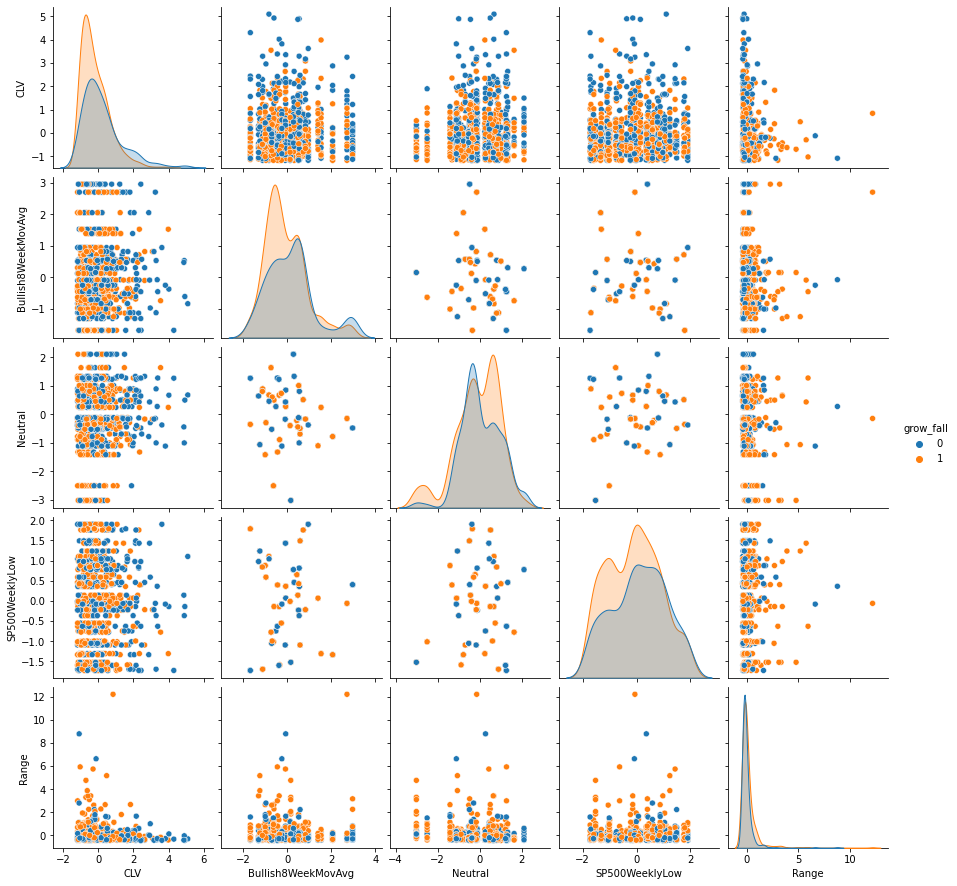

In [8]:
features = sig_f.index.tolist()
X['grow_fall'] = df.grow_fall
pp_data = X[['CLV', 'Bullish8WeekMovAvg', 'Neutral', 'SP500WeeklyLow', 'Range', 'grow_fall']].sample(1000).copy()
pp_data.index = np.arange(len(pp_data))
sns.pairplot(pp_data, hue = 'grow_fall', diag_kind = 'kde')
plt.show()

## PCA feature selection

In [9]:
X = X.drop('grow_fall', axis=1)
cov_mtx = X.cov()

In [10]:
from numpy import linalg as LA
w, v = LA.eig(cov_mtx) # value, vector
e_val = pd.Series(w, index = X.columns)
e_vec = pd.DataFrame(v, index = X.columns, columns = X.columns)


Number of components account for 99%% of variance: 35


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


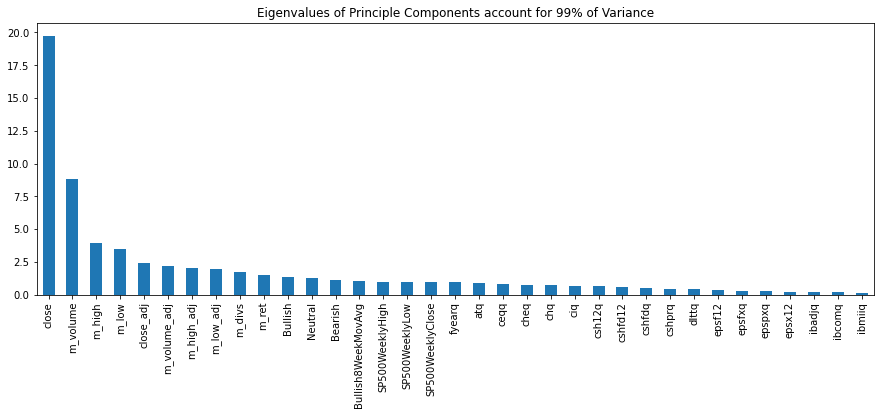

In [11]:
e_val = e_val.sort_values(ascending=False)
pov = e_val/sum(e_val)
cum_pov = np.cumsum(pov)

def find_first_pos(array, x):
    
    i = 0
    while array[i] <= x:
        i += 1
    return i

pos = find_first_pos(cum_pov, 0.99) + 1 # 50% of variance
print('\nNumber of components account for 99%% of variance:', pos)
e_val[:pos].plot.bar(figsize=(15,5), title="Eigenvalues of Principle Components account for 99% of Variance")
plt.show()

# Categorical EDA

Chi-square hypothesis test aims to test whether the count of the target variable in different categories is the same. Thus, if the test yields a p-value lower than 0.05, we could say that the target variable counts of different categories are significantly different.

In [12]:
chi2_test = []

for i in range(len(cat_cols)):
    
    name = cat_cols[i]
    
    # crosstab
    table = pd.crosstab(df['grow_fall'], df[name],)
    f_obs = np.array([table.iloc[0][:].values, 
                      table.iloc[1][:].values])
    
    # chi2 test
    chi, p, dof, expected = stats.chi2_contingency(f_obs)
    chi2_test.append([chi, p])

chi2_test = pd.DataFrame(chi2_test, index=cat_cols, columns=["Chi2_stats", "p_value"])
sig_chi = chi2_test[chi2_test.p_value < 0.05].sort_values('p_value')
sig_chi

,Chi2_stats,p_value
gind,300.229320,1.760226e-35
gsubind,413.322845,2.461675e-33
ggroup,198.843954,5.780280e-32
gsector,130.267001,2.490544e-24
comp_id,1895.223088,6.294901e-13


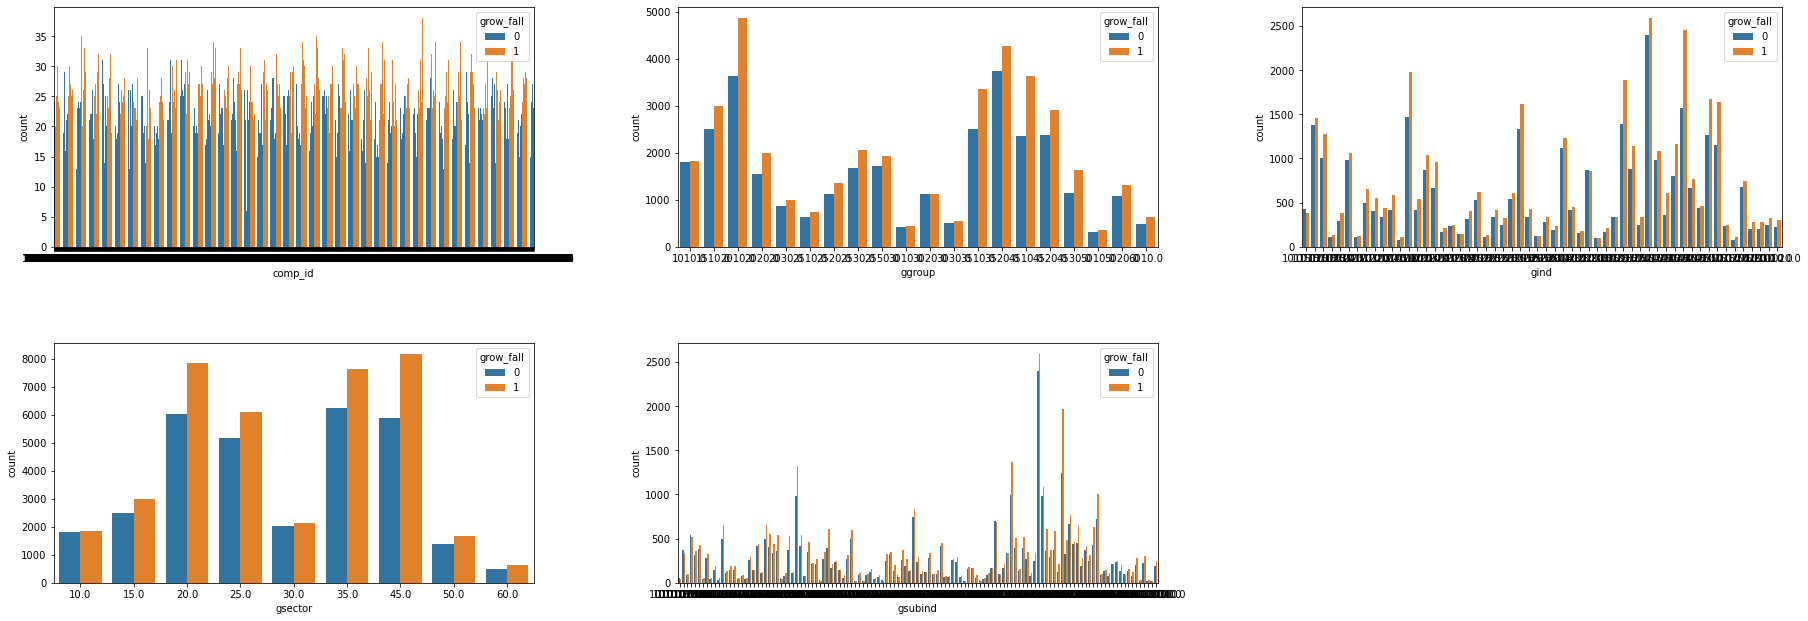

In [13]:
# Plot countplot
plt.figure(figsize=(30,10))
a,b,c = 2,3,1

for i in range(len(cat_cols)):
    
    name = cat_cols[i]
    
    # Plot the countplot
    plt.subplot(a,b,c)
    sns.countplot(x=name, hue='grow_fall', data=df)
    c+=1

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
plt.show()

In [14]:
# Save selected features to csv
features += sig_chi.index.tolist()
pd.Series(features).to_csv("rfc_features.csv")
print(len(features))

59
